# Structural evolution of H1.0

In [112]:
# Imports
import sys
import json
import pandas as pd
import os
import mdtraj as md
from matplotlib import pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

sys.path.append('../../src')
import data_utils
import analyse_utils
import simulate_utils

plt.rcParams["font.family"] = "STIXGeneral"
plt.rcParams["font.weight"] = "normal"

## Data preparation

In [2]:
# Getting previous experiment json
metadata_path = f'../ortho_h1-0/ortho_h1-0.json'
with open(metadata_path, 'r') as file:
    metadata = json.load(file)
templates = pd.DataFrame(metadata['templates']).transpose()
data = pd.DataFrame(metadata['data']).transpose()

In [3]:
# Getting previous analysis results containing outlier definitions
ortho = pd.read_pickle('../ortho_h1-0/results/analysis.pkl')

In [4]:
# Filtering sequences by previous outlier definition
data = data[~ortho.outlier]
templates = templates.loc[data.index]

### Content consensus sequence

In [35]:
# Generating average sequence
avg = data_utils.average_sequence(data['sequence'])
avg

'KEAVAKASAKKSKKTKSKPAARVKEDVPAPTRVKPFKKPKASKSPVKKAKAAKPAAKKKKSSKKKLKKRTKGKPKGTAKPASKAPKKTAPKKAKAGKPKKVKAKATVPA'

In [36]:
# Saving sequence
avg_name = 'H1-0_AVG'
file_path = f'data/{avg_name}.fasta'
with open(file_path, 'w') as file:
    file.write(">" + avg_name + "\n")
    file.write(avg + "\n")

#### Terminally clustered sequence

In [29]:
# Generating terminally clustered sequence
avg_clust = data_utils.cluster_seq(avg, ['K', 'R'], ['D', 'E'], seed=0)

In [30]:
# Saving sequence
avg_clust_name = 'H1-0_AVG_CLUST'
file_path = f'data/{avg_clust_name}.fasta'
with open(file_path, 'w') as file:
    file.write(">" + avg_clust_name + "\n")
    file.write(avg_clust + "\n")

### Metadata

In [37]:
# Saving new experiment json
metadata['data'] = {
    avg_name: {'template': list(templates.index), 'sequence': avg, 'location': None, 'region': 'CTD', 'variant': 'Averaged'},
    avg_clust_name: {'template': list(templates.index), 'sequence': avg_clust, 'location': None, 'region': 'CTD', 'variant': 'Averaged and clustered charges'}
    }
metadata_path = f'idpevo_h1-0.json'
with open(metadata_path, 'w') as file:
    json.dump(metadata, file, indent=4)

## Analysis

In [6]:
# Loading metadata
metadata = analyse_utils.load_metadata('idpevo_h1-0.json', join=False)[0]
seq = metadata.iloc[0].sequence
metadata

,template,sequence,location,region,variant
H1-0_AVG,"[0_AUSLI, 1_CYPVA, 2_FUNHE, 3_KRYMA, 4_NOTFU, ...",KEAVAKASAKKSKKTKSKPAARVKEDVPAPTRVKPFKKPKASKSPV...,None,CTD,Averaged
H1-0_AVG_CLUST,"[0_AUSLI, 1_CYPVA, 2_FUNHE, 3_KRYMA, 4_NOTFU, ...",KKKKKKKKRKKKKKKKKKKKKKRKKKKKKKKRKKKKKKKKKKKKKV...,None,CTD,Averaged and clustered charges


### Sequence characteristics

#### CIDER parameters

In [2]:
# Calculating parameters
cider = analyse_utils.cider_parameters(metadata['sequence'])
cider['Length'] = metadata.sequence.str.len()
cider['Charge'] = (cider.Length * cider.NCPR).astype(int)

cider

NameError: name 'metadata' is not defined

#### Amino acid content

In [17]:
# Calculating frequencies
freqs = analyse_utils.amino_acid_content(metadata.sequence)

freqs

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
H1-0_AVG,0.201835,0.0,0.009174,0.018349,0.009174,0.027523,0.0,0.0,0.385321,0.009174,0.0,0.0,0.119266,0.0,0.027523,0.073394,0.055046,0.06422,0.0,0.0


In [20]:
# Calculating counts
(freqs * len(seq)).astype(int)

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
H1-0_AVG,22,0,1,2,1,3,0,0,42,1,0,0,13,0,3,8,6,7,0,0


### Rg Evolution

In [91]:
# Loading data files
minevo_1 = pd.read_pickle('results/francesco_algorithm/0_1/evolution.pkl')
minevo_2 = pd.read_pickle('results/francesco_algorithm/0_2/evolution.pkl')
minevo_3 = pd.read_pickle('results/francesco_algorithm/0_3/evolution.pkl')
minevo_4 = pd.read_pickle('results/francesco_algorithm/0_4/evolution.pkl')
maxevo = pd.read_pickle('results/francesco_algorithm/10/evolution.pkl')
consevo = pd.read_pickle('results/francesco_algorithm/4.258203/evolution.pkl')

In [4]:
minevo_1.simulate.sum() + minevo_2.simulate.sum() + minevo_3.simulate.sum() + minevo_4.simulate.sum() + maxevo.simulate.sum() + consevo.simulate.sum()

1469

(0.0, 6881.0)

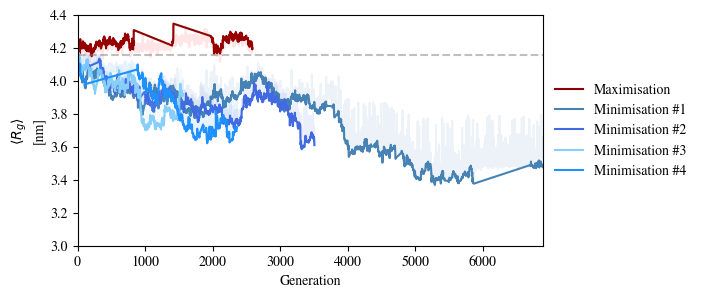

In [90]:
# Plotting results
plt.figure(figsize=(6,3))

plt.plot(maxevo[maxevo.mc].obs, label="Maximisation", c='darkred')
plt.plot(maxevo.obs, alpha=0.1, c='red')

plt.plot(minevo_1[minevo_1.mc].obs, label="Minimisation #1", c='steelblue')
plt.plot(minevo_1.obs, alpha=0.1, c='steelblue')

plt.plot(minevo_2[minevo_2.mc].obs, label="Minimisation #2", c='royalblue')
plt.plot(minevo_2.obs, alpha=0.1, c='royalblue')

plt.plot(minevo_3[minevo_3.mc].obs, label="Minimisation #3", c='lightskyblue')
plt.plot(minevo_3.obs, alpha=0.1, c='lightskyblue')

plt.plot(minevo_4[minevo_4.mc].obs, label="Minimisation #4", c='dodgerblue')
plt.plot(minevo_4.obs, alpha=0.1, c='dodgerblue')

plt.hlines(maxevo.iloc[0].obs, 0, len(minevo_1), color='grey', linestyles='--', alpha=0.5)
plt.xlim(0,len(minevo_1))
plt.ylim(3.0,4.4)

plt.xlabel("Generation")
plt.ylabel("$\left\langle R_g \\right\\rangle$\n[nm]")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.xlim(0)


In [4]:
# Determining efficacy
print('-', minevo_1.obs[0] - minevo_1.obs.min())
print('-', minevo_2.obs[0] - minevo_2.obs.min())
print('-', minevo_3.obs[0] - minevo_3.obs.min())
print('-', minevo_4.obs[0] - minevo_4.obs.min())
print('+', maxevo.obs.max() - maxevo.obs[0])

- 0.7836789233061086
- 0.5714942565566252
- 0.4618673586061761
- 0.5523204847975327
+ 0.19063249743016364


#### Minimization

In [17]:
cider = analyse_utils.cider_parameters(minevo_1[minevo_1.mc].apply(lambda row: ''.join(row.fasta), axis=1))
cider

,kappa,FCR,NCPR,Hydrophobicity,Frac. dis. prom.
0,0.182430,0.440367,0.385321,3.17156,0.917431
2,0.182430,0.440367,0.385321,3.17156,0.917431
3,0.182430,0.440367,0.385321,3.17156,0.917431
4,0.182430,0.440367,0.385321,3.17156,0.917431
6,0.191479,0.440367,0.385321,3.17156,0.917431
...,...,...,...,...,...
6872,0.499927,0.440367,0.385321,3.17156,0.917431
6873,0.499927,0.440367,0.385321,3.17156,0.917431
6875,0.499927,0.440367,0.385321,3.17156,0.917431
6876,0.499927,0.440367,0.385321,3.17156,0.917431


(3.4, 4.4)

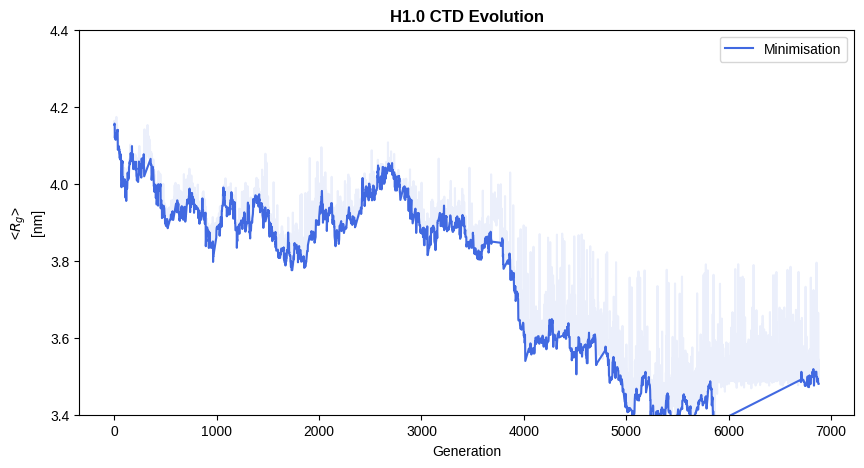

In [6]:
# Plotting results
plt.figure(figsize=(10,5))
plt.plot(minevo_1[minevo_1.mc].obs, label="Minimisation", c='royalblue')
plt.plot(minevo_1.obs, alpha=0.1, c='royalblue')

plt.xlabel("Generation")
plt.ylabel("<$R_g$>\n[nm]")
plt.legend()
plt.title("H1.0 CTD Evolution", fontweight='bold')
plt.ylim(3.0,4.4)


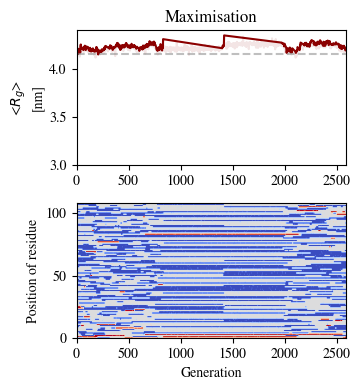

In [27]:
evo = maxevo
seqs = np.array(evo.fasta.to_list())
charges = (np.zeros(shape=seqs.shape) + (seqs == 'K') + (seqs == 'R') - (seqs == 'D') - (seqs == 'E'))

fig, axes = plt.subplots(2,1, figsize=(3.7,4))

axes[0].set_title("Maximisation")
axes[0].plot(evo[evo.mc].obs, label="Minimisation", c='darkred')
axes[0].plot(evo.obs, alpha=0.1, c='darkred')
axes[0].set_ylabel("<$R_g$>\n[nm]")
axes[0].set_xlim(0, len(evo))
axes[0].hlines(evo.iloc[0].obs, *axes[0].get_xlim(), color='grey', alpha=0.5, linestyle='--')
axes[0].set_ylim(3,4.4)
#axes[0].set_title("H1.0 CTD Evolution", fontweight='bold')

pos = axes[1].imshow(charges.T, aspect='auto', cmap='coolwarm_r')
#fig.colorbar(pos, ax=axes[1], ticks=[-1,0,1], location='bottom', shrink=0.2, label='Charge')
axes[1].set_xlabel("Generation")
axes[1].set_ylabel("Position of residue")
#axes[1].set_title("Charge patterning")
axes[1].set_xlim(0)
axes[1].set_ylim(0,108)

plt.tight_layout()

In [31]:
# Finding variant Rg's
variant_sc_sim_dir = "../prota_variant/results/single_chain/default"
variants = {}
for dir in os.listdir(variant_sc_sim_dir):
    kappa = float(dir[-4:])
    print(dir, os.listdir(variant_sc_sim_dir+'/'+dir))

H1-0_VAR_k0.92 ['simulate.log', 'traj.dcd', 'restart.chk', 'top.pdb', 'system.xml', 'traj.log']
H1-0_VAR_k0.36 ['simulate.log', 'traj.dcd', 'restart.chk', 'top.pdb', 'system.xml', 'traj.log']
H1-0_VAR_k0.75 ['simulate.log', 'traj.dcd', 'restart.chk', 'top.pdb', 'system.xml', 'traj.log']
H1-0_VAR_k0.46 ['simulate.log', 'traj.dcd', 'restart.chk', 'top.pdb', 'system.xml', 'traj.log']
H1-0_VAR_k0.11 ['simulate.log', 'traj.dcd', 'restart.chk', 'top.pdb', 'system.xml', 'traj.log']
H1-0_VAR_k0.89 ['simulate.log', 'traj.dcd', 'restart.chk', 'top.pdb', 'system.xml', 'traj.log']
H1-0_VAR_k0.55 ['simulate.log', 'traj.dcd', 'restart.chk', 'top.pdb', 'system.xml', 'traj.log']
H1-0_VAR_k0.80 ['simulate.log', 'traj.dcd', 'restart.chk', 'top.pdb', 'system.xml', 'traj.log']
H1-0_VAR_k0.14 ['simulate.log', 'traj.dcd', 'restart.chk', 'top.pdb', 'system.xml', 'traj.log']
H1-0_VAR_k0.50 ['simulate.log', 'traj.dcd', 'restart.chk', 'top.pdb', 'system.xml', 'traj.log']
H1-0_VAR_k0.18 ['simulate.log', 'traj.dc

### Benchmarking against clustered charges

In [8]:
# Loading single simulation
avg_clust_traj = md.load_dcd("results/avg_clust/traj.dcd", "results/avg_clust/top.pdb")

In [45]:
# Calculating Rg
avg_clust_rg = analyse_utils.compute_rg(avg_clust_traj).mean()
avg_clust_rg

2.979121927960826

In [46]:
# Finding sequence
avg_clust_seq = ''.join(simulate_utils.extract_sequences(avg_clust_traj.topology).aa)
avg_clust_seq

'KKKKKKKKRKKKKKKKKKKKKKRKKKKKKKKRKKKKKKKKKKKKKVFSAPAAAPAAVVSPSSASPLAPVTTGAPPGTATPASAAPAATAPVPAAAGSPSAVPAVATEDE'

In [50]:
# Calculating cider parameters
avg_clust_cider = analyse_utils.cider_parameters(avg_clust_seq)
avg_clust_cider

,kappa,FCR,NCPR,Hydrophobicity,Frac. dis. prom.
0,0.995291,0.440367,0.385321,3.17156,0.917431


### Clustering

In [92]:
# Combining evolution siulation results
allevo = pd.concat([minevo_1, minevo_2, minevo_3, minevo_4, maxevo, consevo])
allevo = allevo[allevo.simulate]
allevo = allevo[['obs', 'fasta']]
allevo.columns = ['Rg', 'sequence']
allevo['sequence'] = allevo['sequence'].apply(''.join)
allevo

,Rg,sequence
0,4.153524,KEAVAKASAKKSKKTKSKPAARVKEDVPAPTRVKPFKKPKASKSPV...
7,4.134516,KSAAVKASAKKSKKTKSKPAVRVKEDAPAPTRVKPFKKPKASKAPV...
15,4.141864,KSAAVKASAKKAKKTKSKPAVRKKEDAPKPTRVKPFKKPVAVKEPV...
33,4.139975,KSAAVKASAKKATKKKSKPAVRKKEDAPKPTRVKPFKKPVASKEPV...
35,4.087962,KSAKVKASAKKATKKKSKPAVRKKEDAPKPTRVKPFKKPVASAEPV...
...,...,...
1599,4.211302,SRKPAPAKPKPKKSKSVKDAAAVSGTKPKKAPRASKKKATKVVKAT...
1600,4.238542,SRKPAPAKPKPKKSKSVKDAAAVSKTKPKKAPRASKKKATKVVKAT...
1607,4.224883,SRKPAPAKPAPKKSKSVKDAAAVSKPKPKKAPRASKKKATKVVKAT...
1616,4.208535,SRKPAAAKPKPKKSKSVKDAAAVSKPKPKKKPRAVKKKAKKVVKPT...


#### By $R_g$

In [141]:
# Using Rg for clustering
features = pd.DataFrame({'Rg': allevo['obs'].astype(float)})
features

,Rg
0,4.153524
7,4.134516
15,4.141864
33,4.139975
35,4.087962
...,...
1599,4.211302
1600,4.238542
1607,4.224883
1616,4.208535


In [ ]:
# Calculating inertia
inertias = []
max_k = 20
for k in range(1, max_k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertias.append(kmeans.inertia_)

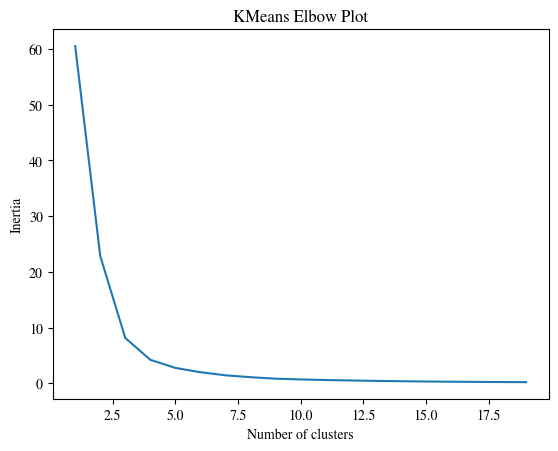

In [143]:
# Elbow plot
plt.plot(range(1, max_k), inertias)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('KMeans Elbow Plot')
plt.show()

In [144]:
# Clustering
kmeans = KMeans(n_clusters=20)
kmeans.fit(features)

/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=20)

In [147]:
# Choosing centroid based on Rg from fitted cluster center
centroid_sequences = []
centroid_Rgs = []
for i in range(kmeans.n_clusters):

    centroid_fit = kmeans.cluster_centers_[i]
    cluster = features.reset_index(drop=True).iloc[kmeans.labels_ == i]

    centroid_distance = abs(cluster - centroid_fit)
    centroid_idx = centroid_distance.Rg.idxmin()
    centroid = allevo.iloc[centroid_idx].sequence
    centroid_Rg = allevo.iloc[centroid_idx].Rg

    print(centroid)
    centroid_sequences.append(centroid)
    centroid_Rgs.append(centroid_Rg)

KKKAKKSAKKKKVKKKTKKKKKKKKKAKKAKKKVPTAVPDGAVAVVEPAAPALAEGFAATPGSTPKPSASKTPSAKKPTKASRPAKPKRSAKPAAKPKKKRKKKAKSVA
VKKVEKAASKKKPKKKAKKKARKKEDKPPAKVAAAFPASTKAAPVSKTKPKAKAKTKKPKSRASTSRPATLAKPKPSAKVKKKAGAKTAGKASKVVKKKGKAKPKKKPP
TKAAAKKAAKKKKKKKKKGSAPKSPVAEVSEVTAAAPAPVKGKDKVKTFKSKPTAPAKKKVTGKRPSAVAAKPPPKAAPKPKKLSARTKKKKKKKKSSRKKKKPAAKKA
VVPAGAVKKKEASAKPAVKKKAKAKPKKKAPKKAKTAPSKAPKKPGLKKKKARSAGKKATSAVTKKKAKPSKRPATAKKVADTSKKKKAKPPAKTSVSPKAERFKPKKK
PKPPTKPAKSGVKKVKKKKPKKKAPKGSAAVKKKAKKKSAAASDPAVEEAGASSVPTAATPKKSKARKKKPKTKSAAFARATTRVPVKLKKAAPKKKKPKKAKKKKKAK
KKKKKPKKKKKKKGKPKKKKKKKKAKKKKKKRAVPVTSGAVASVAVSAAEPDEATASTPTPAPAATPAAAFAASRPPKKPVTKSGKVKKKAKKLSRKPKKKAPASAKKA
KKPPKKKAKPGAKPAKAKSKKPKATKGSVAKKKTRKKVKAAAADPKFEEVGAPPAATLVTPKASKKRAKKKKKKVSVVSASATRTPSKAKKKKPKKPAPKKSKKKKAAA
KKAKKKKKGAAKAPKPAPKRGSVKAAFPKSKSKAKKKKVVSVKVAPPTSTAEDKTKKAKTKKSVKKPRAKVAKTPKEAPAKLAKPPKKPARKTSAKASKKAPAKKAGKK
PKAKKKKKAGKKKKKKAKKAPAKSAPAVVAEPTPRVRSPAPGADSEPVFSTKPKAASPKKKTAKGKSPKKSAKKKKKSKAAKVKAKPTKKKAVKKAPLRTVAKKKTKAA
KKKAKKKTKA

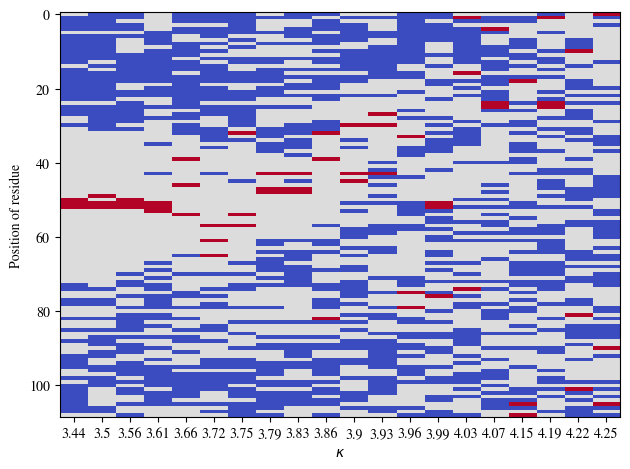

In [148]:
# Checking charge patterning
seqs = np.array([*map(list, centroid_sequences)])[np.array(centroid_Rgs).argsort()]
charges = (np.zeros(shape=seqs.shape) + (seqs == 'K') + (seqs == 'R') - (seqs == 'D') - (seqs == 'E'))

plt.imshow(charges.T, aspect='auto', cmap='coolwarm_r')
plt.xlabel("$\kappa$")
plt.xticks(range(20), sorted([round(k,2) for k in centroid_Rgs]))
plt.ylabel("Position of residue")
plt.tight_layout()

Text(0.5, 1.0, '$R_g$-distribution by cluster')

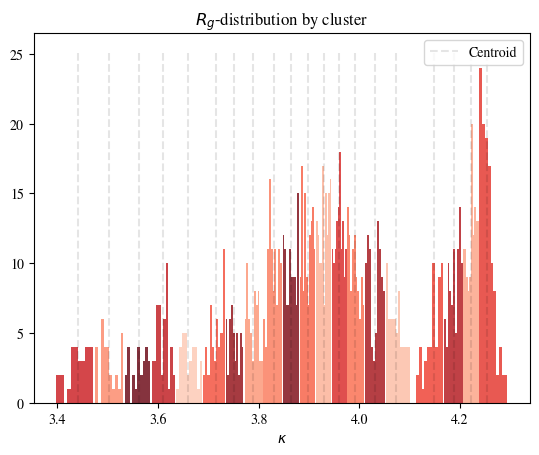

In [159]:
# Sanity checking clusters: Rg
data = features[['Rg']].copy()
data['cluster'] = kmeans.labels_

# Plotting kappa distributions
from matplotlib.cm import ScalarMappable
from matplotlib import colormaps
scmap = ScalarMappable(plt.Normalize(-5,19), colormaps['Reds'])
for i in range(20):
    color = scmap.to_rgba(i)
    plt.hist(data[data.cluster == i].Rg, color=color, alpha=0.8, bins=10)
plt.vlines(centroid_Rgs, *plt.ylim(), color='k', alpha=0.1, linestyles='--', edgecolor='k', label='Centroid')
plt.legend()
plt.xlabel("$\kappa$")
plt.ylabel(None)
plt.title("$R_g$-distribution by cluster")

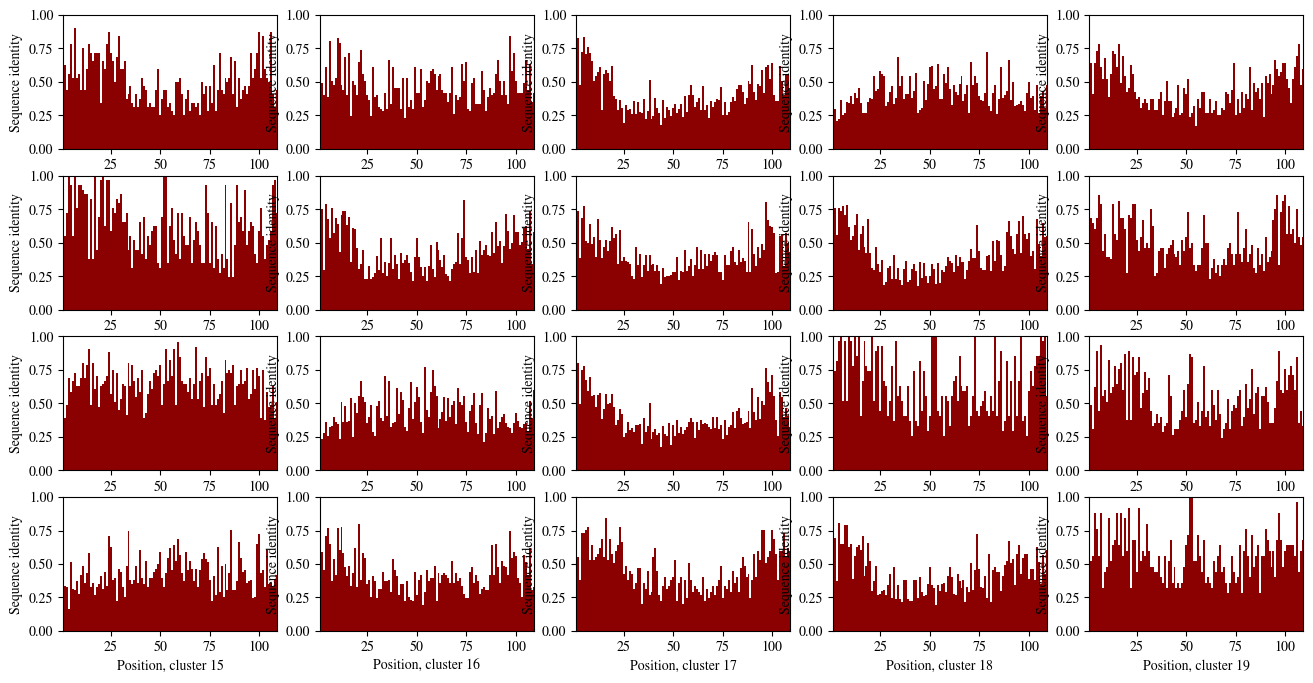

In [160]:
# Sanity checking clusters: Sequence identity
dimensions = (4,5)
fig, axes = plt.subplots(*dimensions, figsize=(16,8))
c = 0
for i in range(dimensions[0]):
    for j in range(dimensions[1]):
        ax = axes[i,j]

        # Calculating sequence identity as interpreted from Bellay 2011
        seqs = np.array(allevo[kmeans.labels_ == c].sequence.apply(lambda s: list(s)).to_list())
        aas = np.array(analyse_utils.amino_acids)

        # Calculating frequency of amino acids in each position, choosing maximum frequency at each position as identity at that position, calculating mean identity
        identity = (seqs[:,:,np.newaxis] == aas).mean(axis=0).max(axis=1)

        # Plotting identity profile
        ax.bar(range(1, len(identity)+1), identity, color="darkred", width=1)
        ax.set_xlim(1, len(identity))
        ax.set_ylim(0,1)
        ax.set_xlabel(f"Position, cluster {c}")
        ax.set_ylabel("Sequence identity")

        c += 1

In [164]:
# Saving cluster sequences for ProTa-binding experiments
data_path = "../prota_variant_v3/data"
for i in range(20):
    Rg = centroid_Rgs[i]
    seq = centroid_sequences[i]
    id = f"H1-0_VAR_Rg{Rg:.2f}"
    print(id)
    desc = f"Artificial H1.0 variant with Rg-value of {Rg}"
    file_path = f'{data_path}/{id}.fasta'
    with open(file_path, 'w') as file:
        file.write(">" + id + " " + desc + "\n")
        file.write(seq + "\n")

H1-0_VAR_Rg3.66
H1-0_VAR_Rg4.07
H1-0_VAR_Rg3.93
H1-0_VAR_Rg4.22
H1-0_VAR_Rg3.79
H1-0_VAR_Rg3.50
H1-0_VAR_Rg3.83
H1-0_VAR_Rg3.99
H1-0_VAR_Rg3.90
H1-0_VAR_Rg3.72
H1-0_VAR_Rg4.15
H1-0_VAR_Rg4.25
H1-0_VAR_Rg3.96
H1-0_VAR_Rg3.44
H1-0_VAR_Rg3.61
H1-0_VAR_Rg4.19
H1-0_VAR_Rg4.03
H1-0_VAR_Rg3.75
H1-0_VAR_Rg3.86
H1-0_VAR_Rg3.56


#### By $R_g$ and $\kappa$

In [25]:
# Using Rg and kappa for clustering
features = pd.DataFrame({'Rg': allevo['Rg'].astype(float),
                         'kappa': allevo.sequence.apply(lambda seq: analyse_utils.SequenceParameters(seq).get_kappa())})
features

,Rg,kappa
0,4.153524,0.182430
7,4.134516,0.189922
15,4.141864,0.169822
33,4.139975,0.200549
35,4.087962,0.164290
...,...,...
1599,4.211302,0.172516
1600,4.238542,0.158197
1607,4.224883,0.147259
1616,4.208535,0.177986


In [106]:
pearsonr(x, y).confidence_interval(0.99)

ConfidenceInterval(low=-0.8710659082112643, high=-0.8345468080986498)

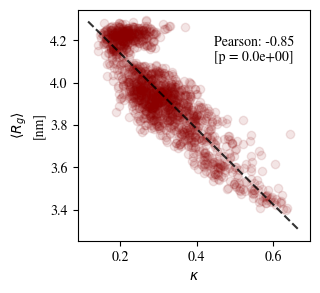

In [115]:
plt.figure(figsize=(3,3))

x = features.kappa
y = features.Rg
plt.scatter(x, y, alpha=0.1, color='darkred')

from scipy.stats import pearsonr
corr, corr_p = pearsonr(x, y)
slope, intercept = np.polyfit(x, y, 1)
plt.plot(plt.xlim(), [slope*x+intercept for x in plt.xlim()], color='k', linestyle='--', alpha=0.8)
plt.text(0.55, 4.1, f"Pearson: {corr:.2f}\n[p = {corr_p:.1e}]", ha='center')

plt.ylabel("$\left\langle R_g \\right\\rangle$\n[nm]")
plt.xlabel("$\kappa$")
plt.show()

In [69]:
# Clustering
kmeans = KMeans(n_clusters=50)
kmeans.fit(features)

/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=50)

In [70]:
# Choosing centroid based on Rg from fitted cluster center
centroid_sequences = []
centroid_Rgs = []
centroid_kappas = []
for i in range(kmeans.n_clusters):

    # Getting feature data for centroid and cluster sequence
    centroid_fit = kmeans.cluster_centers_[i]
    cluster = features.iloc[kmeans.labels_ == i].to_numpy()

    # Calculating distance, scaling for each measure
    centroid_distance = abs(cluster - centroid_fit)
    centroid_distance = (centroid_distance/centroid_distance.std(axis=0)).sum(axis=1)

    # Finding closest sequence to centroid
    centroid_idx = centroid_distance.argmin()
    centroid = allevo[kmeans.labels_ == i].iloc[centroid_idx].sequence
    centroid_Rg = features[kmeans.labels_ == i].iloc[centroid_idx].Rg
    centroid_kappa = features[kmeans.labels_ == i].iloc[centroid_idx].kappa

    print(centroid)
    centroid_sequences.append(centroid)
    centroid_Rgs.append(centroid_Rg)
    centroid_kappas.append(centroid_kappa)

KKAKKKKKGAAKAPKPAPKRGKVKAAFPKSKSKAKSKKVVSVKVAPPTSTAEDKTKKAKTKKSVKKPRAKAAVTPAEAPAKLAKPPKKPARKTSAKASKKKPKKKAGKK
VAAKAKKAAAKVKKKKKKPPGKRKKAAKKRKKKVKKKPSKAPSTSLSAAPATVPPPPAATVFSPEEVTDTGAKPAKVKKKASKKSRAKKAKGKKKKKKATPKSKPKAKA
PEKRKSTSAPSSKGATPLPVTPAKKAKVKSTAKKAFSKVKRKKAKKPAKKAVKPAAKAKKSPKVKKAKADGKKPKVTTRGAVPAKKEKAKKKAKAPPAKKKSAKKPKKA
KKKKKKAKKKKKTKAKKKKPLAATPAKPKSVAKEVAKGASRSAKFSVTGAPRKVKKPRKSVKKAPPKSAAPAPKADAPSEPAKASAKKTKKVAPAKKKTKKAKKTKPGV
KSKKGKKPKKKAKVKAKAKKKKKKKKKKKKRRSAKSTSAAAAVVASSATEPDEGAVAAPTPAFAPPPAAVPPTSAAKPTVKAKKGKTKKKPKKLPRKPKKKKAVSAKKK
KKPPTKPAKVGKKKAKKKKPKKKASPGSAAVKKKAKKKSAAASDPAVEEAGKPSVPTAATPAKSKARKKKPKTKSAAFSRATTRVPVKLKKAAPKKKKPKKAKKKKKAV
FAGKKAAKAKKLPPKKPTPKARKVPSAARTKKSVKKSKPKAKADPAVEVAKAASSAPKKPKKVKTAKPAKEKRKTKSKAAPSTAKPTKVKSKAKKGKKKKKGVPKAKKA
KKPKGAKKTPAKKKPKKKKDKKVVLKVAKKPKKKKPTAAPAPPGKSKTSTTVEAAAAPSKEKSAKKRKVKPAAAFPSASKSKAKVATKKAKKPAKKKVRAKGAAKPRKS
KKKKKAKRKKKKKKAKKKKKKAKKAKKKGPKVAAPAAGSSPATPPASAFTEDEAVSTVSAAPPPATATVPVPAKKSAKGAPAKVRKPVLAASKKKKSTRKKKKKKKKKP
EAAKKKTSKK

(0.0, 1.0)

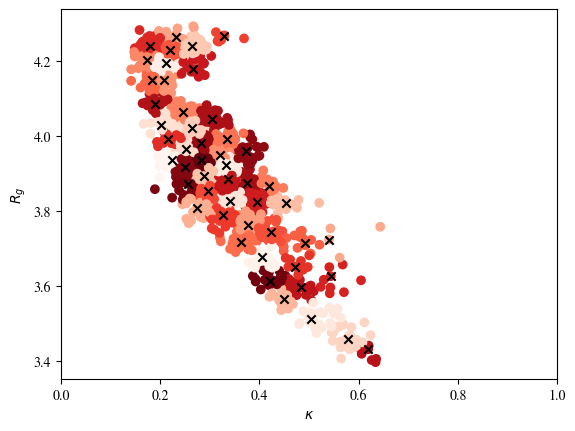

In [73]:
# Checking centroids
plt.scatter(features.kappa, features.Rg, c=kmeans.labels_/kmeans.n_clusters, cmap='Reds')
plt.scatter(centroid_kappas, centroid_Rgs, color='k', marker='x')
plt.xlabel('$\kappa$')
plt.ylabel('$R_g$')
plt.xlim(0,1)

In [74]:
# Saving cluster sequences for ProTa-binding experiments
data_path = "../prota_variant_comb/data"
for i in range(kmeans.n_clusters):
    Rg = centroid_Rgs[i]
    kappa = centroid_kappas[i]
    seq = centroid_sequences[i]
    id = f"H1-0_VAR_Rg{Rg:.2f}_k{kappa:.2f}"
    print(id)
    desc = f"Artificial H1.0 variant with Rg-value of {Rg} and kappa-value of {kappa}"
    file_path = f'{data_path}/{id}.fasta'
    with open(file_path, 'w') as file:
        file.write(">" + id + " " + desc + "\n")
        file.write(seq + "\n")

H1-0_VAR_Rg3.94_k0.22
H1-0_VAR_Rg3.68_k0.41
H1-0_VAR_Rg4.19_k0.21
H1-0_VAR_Rg3.92_k0.33
H1-0_VAR_Rg3.51_k0.50
H1-0_VAR_Rg3.83_k0.34
H1-0_VAR_Rg4.03_k0.20
H1-0_VAR_Rg3.97_k0.25
H1-0_VAR_Rg3.46_k0.58
H1-0_VAR_Rg4.02_k0.26
H1-0_VAR_Rg4.24_k0.26
H1-0_VAR_Rg3.89_k0.29
H1-0_VAR_Rg3.82_k0.45
H1-0_VAR_Rg3.57_k0.45
H1-0_VAR_Rg3.81_k0.27
H1-0_VAR_Rg3.72_k0.54
H1-0_VAR_Rg4.26_k0.23
H1-0_VAR_Rg3.76_k0.38
H1-0_VAR_Rg4.15_k0.21
H1-0_VAR_Rg3.95_k0.32
H1-0_VAR_Rg4.20_k0.17
H1-0_VAR_Rg4.07_k0.25
H1-0_VAR_Rg3.87_k0.42
H1-0_VAR_Rg3.99_k0.34
H1-0_VAR_Rg3.72_k0.36
H1-0_VAR_Rg4.15_k0.18
H1-0_VAR_Rg3.72_k0.49
H1-0_VAR_Rg4.23_k0.22
H1-0_VAR_Rg3.74_k0.42
H1-0_VAR_Rg3.85_k0.30
H1-0_VAR_Rg4.27_k0.33
H1-0_VAR_Rg3.79_k0.33
H1-0_VAR_Rg3.65_k0.47
H1-0_VAR_Rg3.99_k0.22
H1-0_VAR_Rg4.24_k0.18
H1-0_VAR_Rg3.63_k0.54
H1-0_VAR_Rg3.83_k0.39
H1-0_VAR_Rg4.18_k0.27
H1-0_VAR_Rg3.89_k0.34
H1-0_VAR_Rg3.60_k0.48
H1-0_VAR_Rg3.43_k0.62
H1-0_VAR_Rg4.09_k0.19
H1-0_VAR_Rg4.05_k0.30
H1-0_VAR_Rg3.88_k0.37
H1-0_VAR_Rg3.98_k0.28
H1-0_VAR_R

### Kappa Evolution

#### Initial min/max/cons

In [2]:
# Copy results to BINF
!scp -r "fend01:~/OrthoIDP/exp/idpevo_h1-0/results/min" results
!scp -r "fend01:~/OrthoIDP/exp/idpevo_h1-0/results/max" results
!scp -r "fend01:~/OrthoIDP/exp/idpevo_h1-0/results/cons" results

evolution.csv                                 100%   15MB  21.9MB/s   00:00    
evolution.csv                                 100%   15MB  23.0MB/s   00:00    
evolution.csv                                 100%   15MB  21.2MB/s   00:00    


In [28]:
# Loading results
minevo = pd.read_csv("results/min/evolution.csv")
minevo.target = 0
maxevo = pd.read_csv("results/max/evolution.csv")
maxevo.target = 1
consevo = pd.read_csv("results/cons/evolution.csv")
consevo.target = 0.1889910274293869

In [4]:
# Checking annealings
for evo in [minevo, maxevo, consevo]:
    print(f"At generation {len(evo)} with acceptance ratio {sum(evo.mc)/len(evo):.1%} and control parameter value of {evo.c.iloc[-1]} after {len(evo.c.unique())-1} annealings")

At generation 99991 with acceptance ratio 58.0% and control parameter value of 0.0001445751543497 after 458 annealings
At generation 99991 with acceptance ratio 50.6% and control parameter value of 0.0001445751543497 after 458 annealings
At generation 99991 with acceptance ratio 61.3% and control parameter value of 0.0001445751543497 after 458 annealings


(0.0, 1.0)

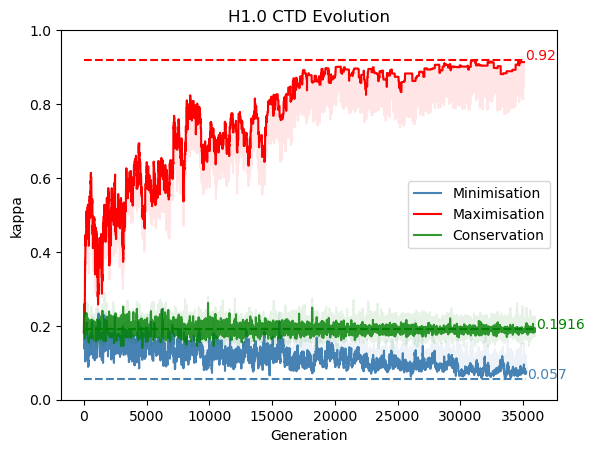

In [91]:
# Plotting results
plt.plot(minevo[minevo.mc].observable, label="Minimisation", c='steelblue', alpha=1)
plt.plot(minevo.observable, alpha=0.1, c='steelblue')
plt.hlines(minevo.observable.min(), 0, len(minevo), color='steelblue', linestyles='--')
plt.text(len(minevo)+100, minevo.observable.min(), f"{minevo.observable.min():.2}", color='steelblue')

plt.plot(maxevo[maxevo.mc].observable, label="Maximisation", c='red', alpha=1)
plt.plot(maxevo.observable, alpha=0.1, c='red')
plt.hlines(maxevo.observable.max(), 0, len(maxevo), color='red', linestyles='--')
plt.text(len(maxevo)+100, maxevo.observable.max(), f"{maxevo.observable.max():.2}", color='red')

plt.plot(consevo[consevo.mc].observable, label="Conservation", c='green', alpha=0.8)
plt.plot(consevo.observable, alpha=0.1, c='green')
plt.hlines(consevo.observable.mean(), 0, len(consevo), color='green', linestyles='--')
plt.text(len(consevo)+100, consevo.observable.mean(), f"{consevo.observable.mean():.4f}", color='green')

plt.xlabel("Generation")
plt.ylabel("kappa")
plt.title("H1.0 CTD Evolution")
plt.legend()
plt.ylim(0,1)


In [32]:
# Combining
minevo['evolution'] = "min"
maxevo['evolution'] = "max"
consevo['evolution'] = "cons"
allevo = pd.concat([minevo, maxevo, consevo]).reset_index(drop=True)

In [33]:
maxevo

,generation,sequence,observable,mc,c,evolution
0,0,KEAVAKASAKKSKKTKSKPAARVKEDVPAPTRVKPFKKPKASKSPV...,0.182430,True,0.014427,max
1,1,KEAVAKASAKKSKKTKSKPAARVKEDVPAPTRVKPFKKPKASKPPV...,0.182430,True,0.014427,max
2,2,KEAVAKASAKKSKKTKSKPAARVKEVVPAPTRVKPFKKPKASKPPD...,0.197911,True,0.014427,max
3,3,KEAVAKASAKKSKKTKSKKAARVKEVVPAPTRVKPFKKPKASKPPD...,0.199038,True,0.014427,max
4,4,KEAVASASAKKSKKTKSKKAARVKEVVPAPTRVKPFKKPKASKPPD...,0.237428,True,0.014427,max
...,...,...,...,...,...,...
99986,99986,PVAGPPPPVAAAAPASAAPPVAATPTASAAFSATPGSVESKKKKKK...,0.988761,True,0.000145,max
99987,99987,AVAGPPPPVAAAAPASAAPPVAPTPTASAAFSATPGSVESKKKKKK...,0.988761,True,0.000145,max
99988,99988,AVAGPPPPVAAAAPASAAPPVAPTPTAKAAFSATPGSVESKKKKKK...,0.922799,False,0.000145,max
99989,99989,AVAGPPPPVAAAAPASAAPPVAPTPTASAAFSATPGSVESKKKKKK...,0.988761,True,0.000145,max


#### Kappa range targets

In [75]:
# Copy results to BINF
!scp -r "fend01:~/OrthoIDP/exp/idpevo_h1-0/results/range_" results

evolution.csv                                 100% 7865KB  20.2MB/s   00:00    
evolution.csv                                 100% 7849KB  18.2MB/s   00:00    
evolution.csv                                 100% 7849KB  20.2MB/s   00:00    
evolution.csv                                 100% 7854KB  19.3MB/s   00:00    
evolution.csv                                 100% 7849KB  19.0MB/s   00:00    
evolution.csv                                 100% 7854KB  15.7MB/s   00:00    
evolution.csv                                 100% 7849KB  19.1MB/s   00:00    
evolution.csv                                 100% 7865KB  14.2MB/s   00:00    
evolution.csv                                 100% 4095KB  23.1MB/s   00:00    
evolution.csv                                 100% 7849KB  18.1MB/s   00:00    
evolution.csv                                 100% 7863KB  18.0MB/s   00:00    


In [79]:
# Loading results
evos = []
dir = 'results/range'
for target in os.listdir(dir):
    df = pd.read_csv(f"{dir}/{target}/evolution.csv")
    df['target'] = float(target)
    evos.append(df)
allevo = pd.concat(evos)
allevo

,generation,sequence,observable,mc,c,target
0,0,KKKEKKKPPAKAKAPAKTKAPPKASRSAKPAKGVKVKKDKKVKVAR...,0.034859,True,0.014427,0.7
1,1,KKKEKKKPPAKAKAPAKTKAPVKASRSAKPAKGVKPKKDKKVKVAR...,0.034859,True,0.014427,0.7
2,2,KKKEKKKPPAKAKAPAKTKAPVKASRSAKPAKGVKPKKDKKVKVAR...,0.034859,True,0.014427,0.7
3,3,KKKEKKKPPAKAKAPAKTKAPVKASRSAKPAKGVKPKKDKKVKVAR...,0.034859,True,0.014427,0.7
4,4,KKKEPKKPPAKAKAPAKTKAPVKASRSAKPAKGVKPKKDKKVKVAR...,0.042932,True,0.014427,0.7
...,...,...,...,...,...,...
49986,49986,ARVVTKKGPAASTTLPATSKKKSKKKKKKAGKKKGKKKVDSAPPFS...,0.399771,True,0.001444,0.4
49987,49987,ARVVTKKGPAASTTLPATSKKKSKKKKKKAGKKKGKKKVDSAPPKS...,0.384543,False,0.001444,0.4
49988,49988,ARVVTKKGPAASTTLPATSKKKSKKKKKKAGKKKGKKKVDSAPPFS...,0.399771,True,0.001444,0.4
49989,49989,ARVVTKKGPAASTTLPATSKKKSKKKKKKAGKKKGKKKVDSAPPPS...,0.399771,True,0.001444,0.4


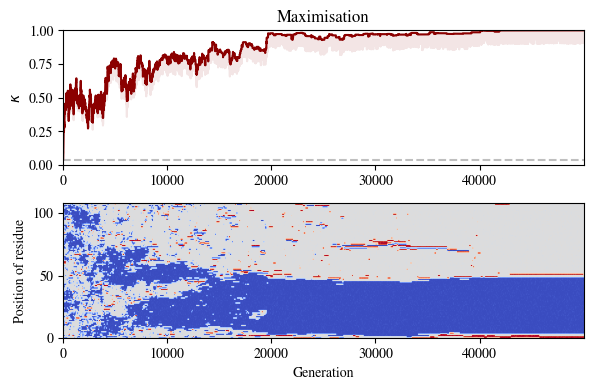

In [91]:
evo = allevo[allevo.target == 1]
seqs = np.array(evo.sequence.apply(list).to_list())
charges = (np.zeros(shape=seqs.shape) + (seqs == 'K') + (seqs == 'R') - (seqs == 'D') - (seqs == 'E'))

fig, axes = plt.subplots(2,1, figsize=(6,4))

axes[0].set_title("Maximisation")
axes[0].plot(evo[evo.mc].observable, label="Minimisation", c='darkred')
axes[0].plot(evo.observable, alpha=0.1, c='darkred')
axes[0].set_ylabel("$\kappa$")
axes[0].set_xlim(0, len(evo))
axes[0].hlines(evo.iloc[0].observable, *axes[0].get_xlim(), color='grey', alpha=0.5, linestyle='--')
axes[0].set_ylim(0,1)

pos = axes[1].imshow(charges.T, aspect='auto', cmap='coolwarm_r')
axes[1].set_xlabel("Generation")
axes[1].set_ylabel("Position of residue")
axes[1].set_xlim(0)
axes[1].set_ylim(0,108)

plt.tight_layout()

[]

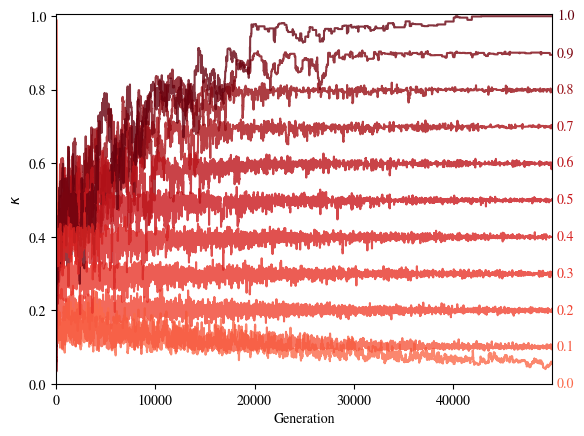

In [109]:
# Plotting results
from matplotlib.cm import ScalarMappable
from matplotlib import colormaps
scmap = ScalarMappable(plt.Normalize(-1,1), colormaps['Reds'])
for target in allevo.target.unique():
    evo = allevo[allevo.target == target]
    color = scmap.to_rgba(target)
    plt.plot(evo[evo.mc].observable, c=color, alpha=0.8)
    #plt.plot(evo.observable, alpha=0.1, c=color)
    #plt.hlines(evo.target.min(), 0, len(evo), color=color, linestyles='--')
    plt.text(evo.index[-1] + 500, evo.target.min(), f"{evo.target.min():.1f}", va='center', color=color)
plt.xlabel("Generation")
plt.xlim(0, evo.index.max())
plt.ylabel("$\kappa$")
#plt.title("H1.0 CTD Evolution")
plt.ylim(0,1.005)
plt.plot()

[]

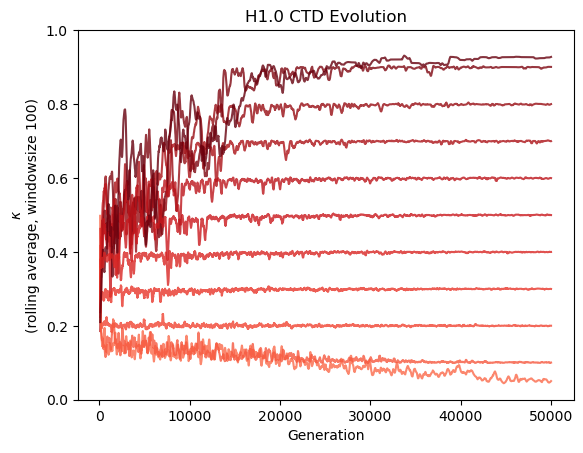

In [418]:
# Plotting results
from matplotlib.cm import ScalarMappable
from matplotlib import colormaps
scmap = ScalarMappable(plt.Normalize(-1,1), colormaps['Reds'])
for target in allevo.target.unique():
    evo = allevo[allevo.target == target]
    color = scmap.to_rgba(target)
    plt.plot(evo[evo.mc].observable.rolling(100).mean(), c=color, alpha=0.8)
plt.xlabel("Generation")
plt.ylabel("$\kappa$\n(rolling average, windowsize 100)")
plt.title("H1.0 CTD Evolution")
plt.ylim(0,1)
plt.plot()

Text(0.5, 1.0, 'Distribution of sequences - Range of targets from 0.0 to 1.0')

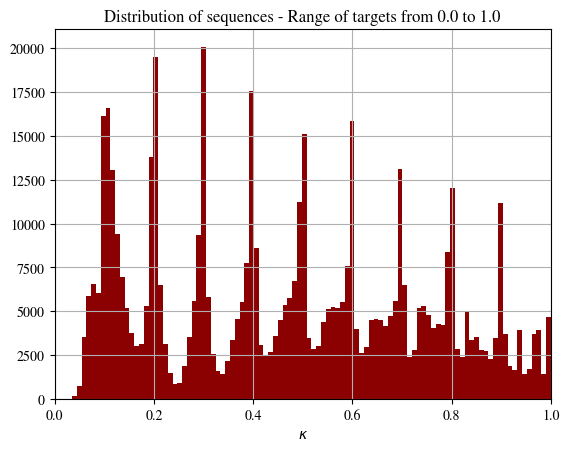

In [110]:
# Plotting distribution
ax = allevo.observable.hist(color='darkred', bins=100)
ax.set_ylabel(None)
ax.set_xlim(0,1)
ax.set_xlabel("$\kappa$")
ax.set_title("Distribution of sequences - Range of targets from 0.0 to 1.0")

#### Clustering

In [ ]:
# Turning sequences to features using OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()
one_hot_matrix = one_hot_encoder.fit_transform(allevo.sequence.apply(list).apply(pd.Series))
one_hot_df = pd.DataFrame.sparse.from_spmatrix(one_hot_matrix).astype(int)

In [ ]:
# Using kappa and sequences for clustering
features = pd.concat([allevo.observable, one_hot_df], axis=1)
seq_len = len(allevo.sequence[0])
features.columns = ["kappa"] + [aa + str(i+1) for i in range(seq_len) for aa in one_hot_encoder.categories_[0]]
features

,kappa,A1,D1,E1,F1,G1,K1,L1,P1,R1,...,E109,F109,G109,K109,L109,P109,R109,S109,T109,V109
0,0.182430,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.182430,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.182430,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.198234,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.197107,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299968,0.186276,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
299969,0.221721,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
299970,0.189357,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
299971,0.189288,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [112]:
# Using only kappa for clustering
features = pd.DataFrame(allevo.observable)
features.columns = ["kappa"]
features

,kappa
0,0.034859
1,0.034859
2,0.034859
3,0.034859
4,0.042932
...,...
49986,0.399771
49987,0.384543
49988,0.399771
49989,0.399771


In [ ]:
# Calculating inertia
inertias = []
max_k = 20
for k in range(1, max_k):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features)
    inertias.append(kmeans.inertia_)

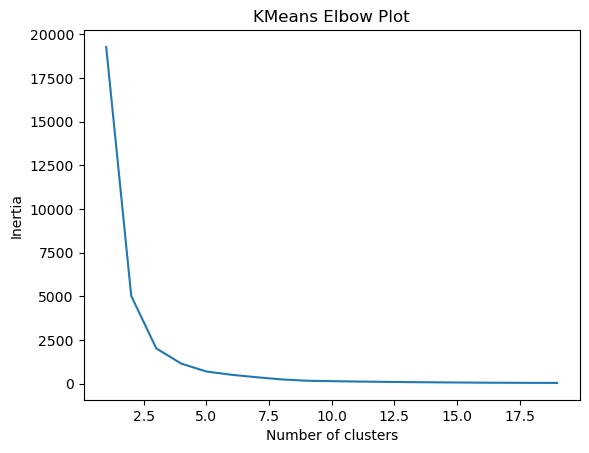

In [237]:
# Elbow plot
plt.plot(range(1, max_k), inertias)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('KMeans Elbow Plot')
plt.show()

In [115]:
# Clustering
kmeans = KMeans(n_clusters=20)
kmeans.fit(features)

/storage1/fknudsen/software/miniconda3/envs/orthoidp/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=20)

In [ ]:
# Choosing centroid based on closest distance from fitted cluster center
centroid_sequences = []
centroid_idxs = []
for i in range(kmeans.n_clusters):

    centroid_fit = kmeans.cluster_centers_[i]#, 1:]
    cluster = one_hot_df.iloc[kmeans.labels_ == i]#, 1:]
    
    centroid_distance = (abs(cluster - centroid_fit)).sum(axis=1)
    centroid_idx = (centroid_distance.idxmin())
    centroid = allevo.sequence[centroid_idx]

    print(centroid)
    centroid_sequences.append(centroid)
    centroid_idxs.append(centroid_idx)

In [129]:
# Choosing centroid based on kappa from fitted cluster center
centroid_sequences = []
centroid_kappas = []
for i in range(kmeans.n_clusters):

    centroid_fit = kmeans.cluster_centers_[i]
    cluster = features.reset_index(drop=True).iloc[kmeans.labels_ == i]

    centroid_distance = abs(cluster - centroid_fit)
    centroid_idx = centroid_distance.kappa.idxmin()
    centroid = allevo.iloc[centroid_idx].sequence
    centroid_kappa = allevo.iloc[centroid_idx].observable

    print(centroid)
    centroid_sequences.append(centroid)
    centroid_kappas.append(centroid_kappa)

VVPAAAAGAPTVSAAASTKKKKKRKVKKKKRKKKKKKKVPTAASSPASAAKPSVAATPPATPKKKKKKKKKKKKKKKKKKRKKKKKSAKETGFSAPPAAGPALVAPPED
AAVPKRAPPLPKPKKKKKKFPKGKTKAAPKKKAAKADAKGKTPATAVVASPVPSTGSTSKKKSTKAKKVKASKKKKKKEPSPKERKKAAAAKKKAKAVKKKRAVKSAKP
GKKTPPKKPKKKKKKASLAPAASPKPSKSPEVAKKRKPTAAKPRAAKAAKGKKKKKKKKKKKKKKVRKKKAKKKKSVTSPAAFVAAAVASPVSTAKKDVEKAAPTAPTG
PAKAAKPSAKKVPSAGKKKAPPSKKAPAKAKKTPATRKGVSKAKKAKSPAAKRKGKPAKTDKKFKEKAKKPVKKAARAAVLPKVKSKEKKSVKAKKSTPPKAKTTKKVK
VPPGPSKSKPAKKKKKKKKKKKKAKAKKKKAKKTGVTVGSAAAPAPKKVRKKKKRKKKKKPSEKKKKKKRKKKSFVAVAVPAAATPAAAPLKAATASATPEPDSPSATA
PKSAKVVKVVARPKKTKPKKKKKKKKKKKKKKRKSSPKSSDAAVAATPKAKKSKRKTKAKAPKAEAPVAAPAEKTGFKTPKAPAAKAKSKALKPKAKKGSTAKVAKGPP
KPSAPKKKKVPAKTALGEKKKDGAAKPKVPKSKAGKAVAAEKRKRKSFPATKSKKKKAKTAAKKPKTAKKAKKTAKSVSAPAVKKKAAKPTAKPKRVAKSPPKKVKSPK
EDSAKKKKKKKRKKKKKKKKKKKKKAKKKKKKKKKKKKKRKKKKKKRKASTPTAASSSPTPSPGVAAVPPAAKEKSATVVAGTGAAAPFAAAPPPPAAATSAALVPVVP
KPPKKKRKKKSKKKKKKKKKKKKKKKKRKKKKKKKRKPKKTSGVASAKAATKAKEVKTASPAGVTPSFGPAPAVAAAPPVPPAASVAAATATASSKAVKEPDKAKAPKL
TGRTVPPKPK

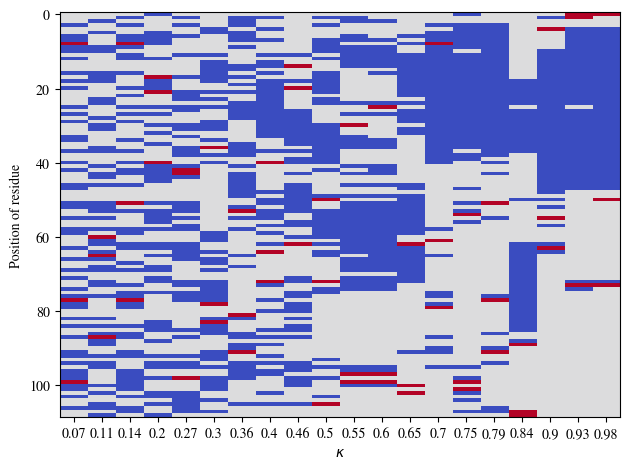

In [130]:
# Checking charge patterning
seqs = np.array([*map(list, centroid_sequences)])[np.array(centroid_kappas).argsort()]
charges = (np.zeros(shape=seqs.shape) + (seqs == 'K') + (seqs == 'R') - (seqs == 'D') - (seqs == 'E'))

plt.imshow(charges.T, aspect='auto', cmap='coolwarm_r')

plt.xlabel("$\kappa$")
plt.xticks(range(20), sorted([round(k,2) for k in centroid_kappas]))
plt.ylabel("Position of residue")

plt.tight_layout()

[]

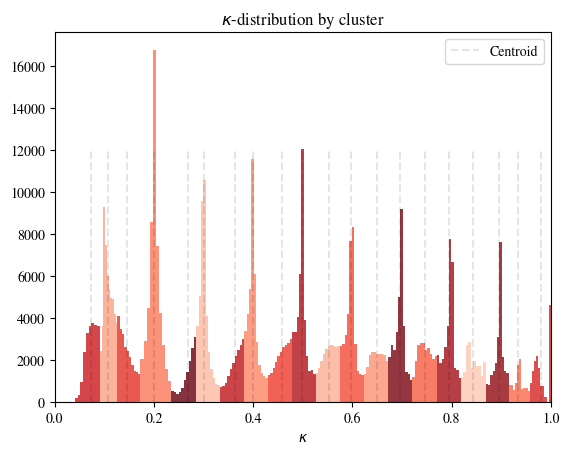

In [131]:
# Sanity checking clusters: Kappa
data = features[['kappa']].copy()
data['cluster'] = kmeans.labels_

# Plotting kappa distributions
from matplotlib.cm import ScalarMappable
from matplotlib import colormaps
scmap = ScalarMappable(plt.Normalize(-5,19), colormaps['Reds'])
for i in range(20):
    color = scmap.to_rgba(i)
    plt.hist(data[data.cluster == i].kappa, color=color, alpha=0.8)
plt.vlines(centroid_kappas, 0, 12000, color='k', alpha=0.1, linestyles='--', edgecolor='k', label='Centroid')
plt.legend()
plt.xlabel("$\kappa$")
plt.ylabel(None)
plt.title("$\kappa$-distribution by cluster")
plt.xlim(0,1)

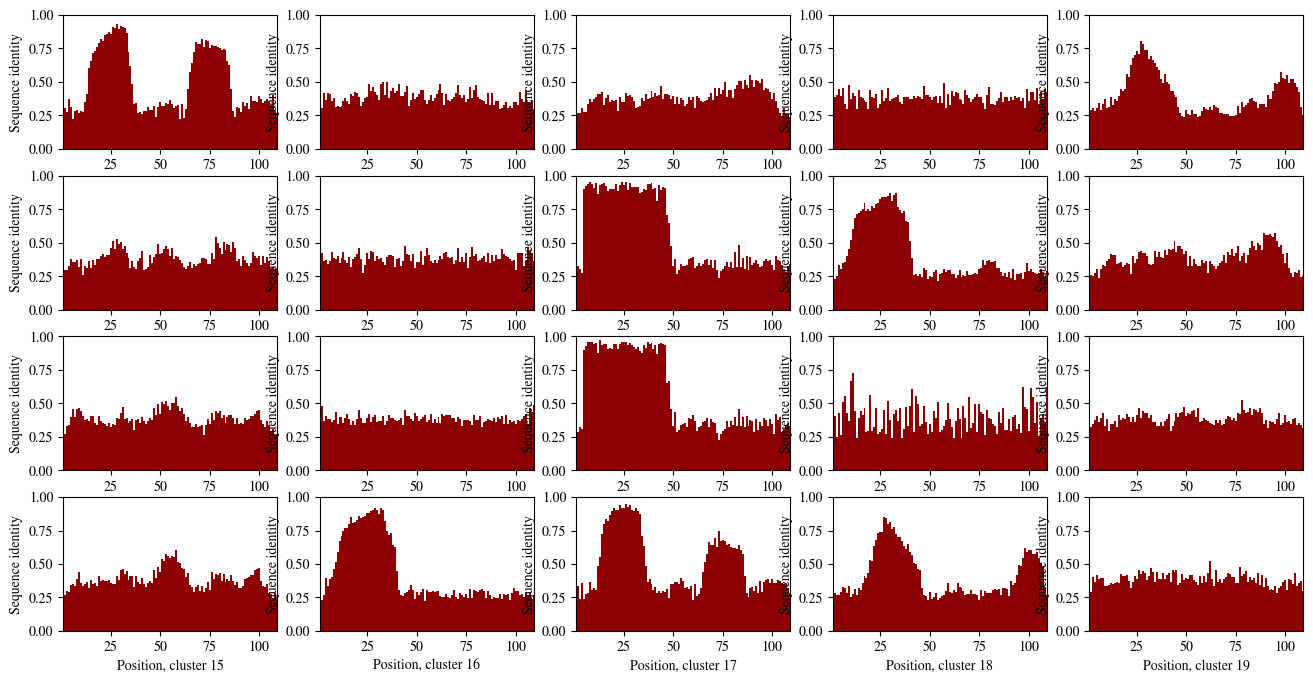

In [132]:
# Sanity checking clusters: Sequence identity
dimensions = (4,5)
fig, axes = plt.subplots(*dimensions, figsize=(16,8))
c = 0
for i in range(dimensions[0]):
    for j in range(dimensions[1]):
        ax = axes[i,j]

        # Calculating sequence identity as interpreted from Bellay 2011
        seqs = np.array(allevo[kmeans.labels_ == c].sequence.apply(lambda s: list(s)).to_list())
        aas = np.array(analyse_utils.amino_acids)

        # Calculating frequency of amino acids in each position, choosing maximum frequency at each position as identity at that position, calculating mean identity
        identity = (seqs[:,:,np.newaxis] == aas).mean(axis=0).max(axis=1)

        # Plotting identity profile
        ax.bar(range(1, len(identity)+1), identity, color="darkred", width=1)
        ax.set_xlim(1, len(identity))
        ax.set_ylim(0,1)
        ax.set_xlabel(f"Position, cluster {c}")
        ax.set_ylabel("Sequence identity")

        c += 1

In [133]:
# Saving cluster sequences for ProTa-binding experiments
data_path = "../prota_variant_v2/data"
for i in range(20):
    kappa = centroid_kappas[i]
    seq = centroid_sequences[i]
    id = f"H1-0_VAR_k{kappa:.2f}"
    print(id)
    desc = f"Artificial H1.0 variant with kappa-value of {kappa}"
    file_path = f'{data_path}/{id}.fasta'
    with open(file_path, 'w') as file:
        file.write(">" + id + " " + desc + "\n")
        file.write(seq + "\n")

H1-0_VAR_k0.84
H1-0_VAR_k0.30
H1-0_VAR_k0.55
H1-0_VAR_k0.11
H1-0_VAR_k0.65
H1-0_VAR_k0.40
H1-0_VAR_k0.20
H1-0_VAR_k0.93
H1-0_VAR_k0.75
H1-0_VAR_k0.60
H1-0_VAR_k0.46
H1-0_VAR_k0.14
H1-0_VAR_k0.98
H1-0_VAR_k0.07
H1-0_VAR_k0.36
H1-0_VAR_k0.50
H1-0_VAR_k0.79
H1-0_VAR_k0.90
H1-0_VAR_k0.70
H1-0_VAR_k0.27


#### Kappa of random sequences

In [18]:
# Generating a lot of random sequences with same composition
seqs = pd.Series([data_utils.shuffle_seq(metadata.loc['H1-0_AVG'].sequence, seed=i) for i in range(10000)])

In [19]:
# Calculating their kappa values
kappas = seqs.apply(lambda s: analyse_utils.SequenceParameters(s).get_kappa())

(0.0, 1.0)

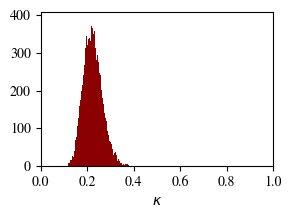

In [59]:
# Plotting
plt.figure(figsize=(3,2))
plt.hist(kappas, bins=100, color='darkred')
plt.ylabel("")
plt.xlabel("$\kappa$")
plt.xlim(0,1)

### Checking single simulations

In [3]:
# Loading evolution
evo = pd.read_pickle('results/francesco_algorithm/0_1/evolution.pkl')

In [6]:
# Choosing generation
gen = evo[evo.simulate].iloc[-1]

5104

In [16]:
# Downloading trajectory
evolution_path = "fend01:~/OrthoIDP/exp/idpevo_h1-0/results/francesco_algorithm/0_1"
traj_path = '/'.join([evolution_path, 'g'+str(gen.name), 'traj.dcd'])
top_path = '/'.join([evolution_path, 'g'+str(gen.name), 'top.pdb'])

!scp $traj_path "results/single_sim/traj.dcd"
!scp $top_path "results/single_sim/top.pdb"

traj.dcd                                      100%   66MB  10.4MB/s   00:06    
top.pdb                                       100%   11KB 301.2KB/s   00:00    


In [ ]:
# Loading trajectory
traj = md.load_dcd("results/single_sim/traj.dcd", "results/single_sim/top.pdb")

In [52]:
# Calculating distances
distances = analyse_utils.compute_distance_contact(traj[:10000])

/tmp/ipykernel_7351/3656941873.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(distances.mean(axis=0), cmap=plt.cm.get_cmap('Greens_r'), vmin=0, vmax=4)


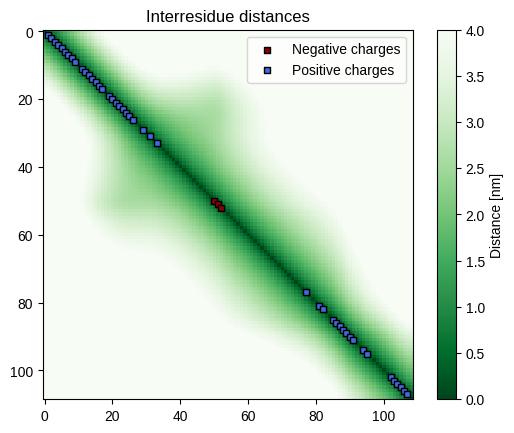

In [58]:
# Plotting distance contact map
plt.imshow(distances.mean(axis=0), cmap=plt.cm.get_cmap('Greens_r'), vmin=0, vmax=4)
plt.title("Interresidue distances")
plt.colorbar(label="Distance [nm]", )

# Plotting negative charges
seq = np.array(gen.fasta)
neg = np.where((seq[:,np.newaxis] == np.array(['D', 'E'])).any(axis=1))
pos = np.where((seq[:,np.newaxis] == np.array(['K', 'R'])).any(axis=1))
plt.scatter(neg, neg, color='darkred', edgecolors='black', marker='s', label="Negative charges", s=15)
plt.scatter(pos, pos, color='royalblue', edgecolors='black', marker='s', label="Positive charges", s=15)
plt.legend()